In [8]:
# We need to import these modules to get started
import numpy as np
import pandas as pd
import os
import sys
import h5py
import scipy as sp

import matplotlib.pyplot as plt
# It would be great to use notebook here, but thats not supported???
%matplotlib inline


# 0 Today

Hubel and Wiesel found orientation and direction selective cells using single wire recordings in the cat primary visual cortex.

To do this, they used a "bespoke" technique - honing in on an individual cell with a high impedence electrode, then manually determining their "best" stimulus to drive that cells behavior. 

In our phasing, we will say that Hubel and Wiesel showed that their exist neurons in V1 that "encode" direction selective information. This was (and still is!) exciting - but it also raises more questions.

Using this idea as a starting place, this Workshop will show how to scale this kind of analysis to survey a population of neurons, and highlight some of the challenges that go with this.



# 0.1 Our Questions here.

(1) Do mice have direction selective visual responses?

(2) How reliable are these responses?

(3) What do these responses look like in the neural population? Are is this a common phenomena? Is it consistant accross cells?

(4) How can we mathematically formalize this analysis?

All of out examples today will use the Allen Brain Observatiory 2-photon dataset. Before we get started, lets find the dataset and ensure we can access it:

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
<p>The main entry point is the `BrainObservatoryCache` class.  This class is responsible for downloading any requested data or metadata as needed and storing it in well known locations.  For this workshop, all of the data has been preloaded into data assetts on codeocean - These data are big, and this will save us a lot of bandwidth and time.

<p>We begin by importing the `BrainObservatoryCache` class and instantiating it.

<p>`manifest_path` is a path to the manifest file. 
</div>

In [9]:
from allensdk.core.brain_observatory_cache import BrainObservatoryCache

#drive_path = '/data/allen-brain-observatory/visual-coding-2p'
drive_path = r'D:/VisualCoding2p'

manifest_file = os.path.join(drive_path,'manifest.json')

boc = BrainObservatoryCache(manifest_file=manifest_file)

In [10]:
# Not putting something after a item at the end of a notebook cell will cause it
# to exicute that items print function. For objects that don't have a print
# function, it will just print the object type. This can be handy durring data exporation.
boc

In [11]:
# Other ways to do this
print(boc)
print(type(boc))

<class 'allensdk.core.brain_observatory_cache.BrainObservatoryCache'>


In [12]:
# Jupyter and VS code will also help you out by giving you a menu of fuctions
# you can call on an object. This is a handy trick when learning a new library.
boc.

SyntaxError: invalid syntax (2964336537.py, line 3)

# 1 Do Mice Have Direction Selective Neurons?

## 1.0 Why bother with mice when we got here using with cats?
Simply put, there are better tools availible for recording and manipulating neural circuits in mice. Because mice have a short generation time, their exist a plethera of genetic tools that exist in mice and not yet in other mammels. The most relevent of these - Ca2+ imaging - makes possible to repeatdily record from a realativly large population of neurons, and therefore make mice the ideal animal for this kind of experiment.

That said, mice are not cats and have very different visual systems. A necessary prerequisite to any sort of survey work will be to demonstrate that mice have similar responses to those seen in other mammels!

## 1.1 Visual stimulus

# 1.1.0 Head Fixation
Neurons in the visual system often have spacially selective receptive fields, that is, they tend to repsond to stimuli shown in a particular part of visual space. In order to repeatably show stimuli to a mouse, the mice need to be head-fixed. For all the datasets you will work with here, this means that mice have had a head-bar surgically implanted prior to the experiment (Groblewski et al 2022). 

![Headframe](../resources/Groblewski_head_fixed_mouse.jpg)

This headbar can be repetably clamped into a recording setup. The clamp used in these experiments does so with < 10um precision. 

![Headframe positioning](../resources/Groblewski_head_bar_lock_in.jpg)

Head fixation allows two things. 

First, this relability allows the mouse to be repoducibly positioned on a rig. For the datasets you will work with in the next couple of weeks, this typically means that the mosue is situatied on a running wheel. A set of cameras monitor the mouse's face, eye position, and pupil size (Cite whitepaper here).

![Mouse On Rig](../resources/MouseOnRig.jpg)

A screen holds positioned in front of the mice can then present stimuli at specific locations in the mouse's field of view. Here, all stimuli were presented to the right side of the mouse.

![Screen On Rig](../resources/ScreenOnRig.jpg)

The second benifit of head fixation is that it holds the mouses head place to facilitate neural recordings. We will return to this in the next session.

# 1.1.1 Visual Stimulation

Now that the mouse is in a repeatable position, it can be shown stimuli. The t Allen Brain Observatory dataset used a battery of stimuli. These includestatic gratings, drifiting gratings, locally sparse noise, natural scenes, and some natural movies. The data also includes periods of no stimulus, which allow for "spontainous" (or at least unstimuluated) neural activity. 

![Visual Stimuli](../resources/VisualStimuli.jpg)

We can use the BrainObservatoryCache to see all the stimuli used:


In [13]:
boc.get_all_stimuli()

['drifting_gratings',
 'locally_sparse_noise',
 'locally_sparse_noise_4deg',
 'locally_sparse_noise_8deg',
 'natural_movie_one',
 'natural_movie_three',
 'natural_movie_two',
 'natural_scenes',
 'spontaneous',
 'static_gratings']

For today's workshop, though, our question is focused on direction selectivity. This means that it makes the most sense to use drifting gratings. Here, gratings are shown accross the whole screen, but moved accross it in specific directions at specific temporal frequencies. The BrainObservatoryCache can rapidly give us an idea about how much data we might have to answer this quesiton. Hint: its a lot.

In [14]:
sessions_with_drifting_gratings = boc.get_ophys_experiments(stimuli=['drifting_gratings'])
len(sessions_with_drifting_gratings)

456



## 1.3 Record Neurons 

### 1.3.0 Every recording is baised; its important to know how.

Our goal here is to look at the activity of individual neurons. In this course, you will see data from two primary ways of doing this; in vivo electophysiology (e.g NeuroPixels data) and 2-photon calcium imaging data. 

This is no one right way to record neural activity- each method has its pluses and minuses. Many of you may have in depth understandings of one or both of these methods, but lets think for a moment about how you might select a recording technique to tackle a particual scientific question.

#### 1.3.0.1 In Vivo Electrophysiology 
In vivo electrophysiology is where you park an electrode next to a cell and record extracellular ion flow from each action potential. 

![neuropixels cartoon](../resources/Model_of_mouse_v1_Barry_Isralewitz_braincontest2021.jpg)

Advantages: 
- Extreamly high time resolution (as fast as you care to sample it). 
- Record from deep structures using longer probes.
- Laminar and structural information
- Record from many structures simultaniously


Disadvantages: 
- You don't know a lot of information about the cells you are recording from.
- Spike sorting - the art of isolating neurons - is an unsolved problem.
- May be baised towards certain kinds of cells (big and/or high firing rate).
- Historically low cell yields per experiment.
- Cannot return to a cell accross sessions or experiments.


### 1.3.0.1 2-Photon Calcium imaging
Calcium imaging is an optical technique. Neurons are geneticially modified to express a GCaMP, a genetically encoded calium indictor that attaches Green Fluorecent Protien (GFP) to calmodulin, a calcium binding protine. As a result, cells will fluoress in a  green wavelenth when these is a calcium influx into the cell. Since calcium concentration spikes during action potentials, this allows for optical imaging of a given cells activity. 

Here is what this looks like when you stimulate a neuron and simultaniously record its electrophysiological (in this case, via patch clamp) and Ca2+ response (Stosiek et al. 2003, PNAS). Notice that there is a single, slow calcium transient for a much faster burst of spikes.

![https://www.pnas.org/doi/10.1073/pnas.1232232100 Stosiek et al 2003](../resources/EphysAndCa2.jpg)


As an historical aside, GFP was discovered here, at Friday Harbor, from the fluoressent jelly fish Aequorea victoria. 

![https://www.thoughtco.com/green-fluorescent-protein-facts-4153062](../resources/AequoreaVictoria.jpg)


Advantages:
- Cell type information by only expressing Ca2+ indicators in certain cell types.
- Return to specific identified cells accross sessions.

Disadvantages
- Activity is recorded indirectly using Ca2+ signal.
- Relativly poor time resolution.
- Limited to one or a few specific fields of view. In these data, that means a specific depth plane, though state-of-the-art techniques can now scan 3d volumes.
- Limated depth without implanting fancy (and distructive) lenses.

### 1.3.0.3 These pro-con lists are subject to change!
We would be remiss if we didn't point out that the these advantages and dissadvantages are rappidly changing, so fucture experiments might choose different methods for different reasons. 
- Ca2+ indicators are getting faster.
- Multi-photon methods are extending the depth-of-field for Ca2+ techniques.
- Better optics are allowing for imaging in deep structures and 3D fields of view.
- Optotagging allows for cell type identification in ephys.
- High density probes inprove cell yeilds in ephys.



## 1.3.1 Looking at Ca2+ data
For today's question, we want to charecterize a population of neurons in visual cortex. This means Ca2+ data makes sense to answer our questions, and we are going to dive deaper into data from the Allen Brain Observatory optical dataset. you will learn more about an analgous ephys dataset tomorrow!

### 1.3.1.1 Intrensic signal imaging to identify brain areas
Intrensic signal imaging is a technique that optically measures hemodyanmic - effectivly changes in blood oxygenation. While it has poor resolution in space and time, it has the distinct advantange of not requiring any fancy dyes or transgenic lines. Because each visual area has a distinct hemodyanimic response to visual stimulation, ISI allows for mapping and localication of specific brain regions. For all the mice in the Brain Observatory, ISI was performed to identify specific visual cortical areas.

![ISI](../resources/ISI.jpg)

Recordings are targeted to particular visual areas and depths

In [15]:
targeted_structures = boc.get_all_targeted_structures()
print('all targeted structures: ' + str(targeted_structures))

all targeted structures: ['VISal', 'VISam', 'VISl', 'VISp', 'VISpm', 'VISrl']


### 1.3.1.2 Cre Lines and Cortical layers
WORDS! Plus reference

https://help.brain-map.org/display/observatory/Allen+Brain+Observatory+-+Overview#:~:text=Intrinsic%20signal%20imaging%20%28ISI%29%20measures%20hemodynamic%20response%20to,field%20to%20corresponding%20locations%20within%20responsive%20cortical%20areas.

In [16]:
# Download a list of all imaging depths
depths = boc.get_all_imaging_depths()
print('all imaging depths: ' + str(depths))

all imaging depths: [175, 185, 195, 200, 205, 225, 250, 265, 275, 276, 285, 300, 320, 325, 335, 350, 365, 375, 390, 400, 550, 570, 625]


In [17]:
# Download a list of all imaging depths
cre_lines = boc.get_all_cre_lines()
print('all cre lines: ' + str(cre_lines))

all cre lines: ['Cux2-CreERT2', 'Emx1-IRES-Cre', 'Fezf2-CreER', 'Nr5a1-Cre', 'Ntsr1-Cre_GN220', 'Pvalb-IRES-Cre', 'Rbp4-Cre_KL100', 'Rorb-IRES2-Cre', 'Scnn1a-Tg3-Cre', 'Slc17a7-IRES2-Cre', 'Sst-IRES-Cre', 'Tlx3-Cre_PL56', 'Vip-IRES-Cre']


<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
<h2>Experiment containers</h2>
<p>The experiment container describes a set of 3 experiment sessions performed at the same location (targeted area and imaging depth) in the same mouse that targets the same set of cells. Note that this targeting is not perfect- many cells will overlap between sessions, but not all. 

Each experiment container has a unique ID number. 
</div>

In [18]:
expt_container_id = 536323956

In [19]:
expt_session_info = boc.get_ophys_experiments(experiment_container_ids=[expt_container_id])
expt_session_info_df = pd.DataFrame(expt_session_info)
expt_session_info_df

,id,imaging_depth,targeted_structure,cre_line,reporter_line,acquisition_age_days,experiment_container_id,session_type,donor_name,specimen_name,fail_eye_tracking
0,540684467,175,VISp,Emx1-IRES-Cre,Ai93(TITL-GCaMP6f),120,536323956,three_session_A,252174,Emx1-IRES-Cre;Camk2a-tTA;Ai93(MG)-252174,False
1,541048140,175,VISp,Emx1-IRES-Cre,Ai93(TITL-GCaMP6f),121,536323956,three_session_B,252174,Emx1-IRES-Cre;Camk2a-tTA;Ai93(MG)-252174,False
2,539515366,175,VISp,Emx1-IRES-Cre,Ai93(TITL-GCaMP6f),113,536323956,three_session_C,252174,Emx1-IRES-Cre;Camk2a-tTA;Ai93(MG)-252174,False


<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
<h2>The Dataset Object</h2>
<p>Each session has a unique `session_id.' These can be used to query a data_set object

</div>

In [27]:
session_id= 540684467
data_set = boc.get_ophys_experiment_data(ophys_experiment_id=session_id)

In [28]:
data_set.get_metadata()

{'sex': 'male',
 'targeted_structure': 'VISp',
 'ophys_experiment_id': 540684467,
 'experiment_container_id': 536323956,
 'excitation_lambda': '910 nanometers',
 'indicator': 'GCaMP6f',
 'fov': '400x400 microns (512 x 512 pixels)',
 'genotype': 'Emx1-IRES-Cre/wt;Camk2a-tTA/wt;Ai93(TITL-GCaMP6f)/wt',
 'session_start_time': datetime.datetime(2016, 8, 23, 11, 45, 14),
 'session_type': 'three_session_A',
 'specimen_name': 'Emx1-IRES-Cre;Camk2a-tTA;Ai93(MG)-252174',
 'cre_line': 'Emx1-IRES-Cre/wt',
 'imaging_depth_um': 175,
 'age_days': 121,
 'device': 'Nikon A1R-MP multiphoton microscope',
 'device_name': 'CAM2P.1',
 'pipeline_version': '3.0'}

In [22]:
data_set.get_dff_traces()

(array([  12.98567,   13.01884,   13.05201, ..., 3852.12818, 3852.16135,
        3852.19453]),
 array([[0.2603065 , 0.26848692, 0.2537276 , ..., 0.4832628 , 0.562328  ,
         0.54916185],
        [0.12359576, 0.14682338, 0.16583093, ..., 0.13301598, 0.2175612 ,
         0.3015457 ],
        [0.15424512, 0.13349123, 0.18023464, ..., 0.14015312, 0.18902878,
         0.26112455],
        ...,
        [0.29815567, 0.16793533, 0.13316172, ..., 0.16471283, 0.20589736,
         0.2314399 ],
        [0.40963152, 0.5189302 , 0.48454905, ..., 0.12588076, 0.10504165,
         0.26602805],
        [0.09165223, 0.19570875, 0.17075698, ..., 0.349869  , 0.15585196,
         0.40525788]], dtype=float32))

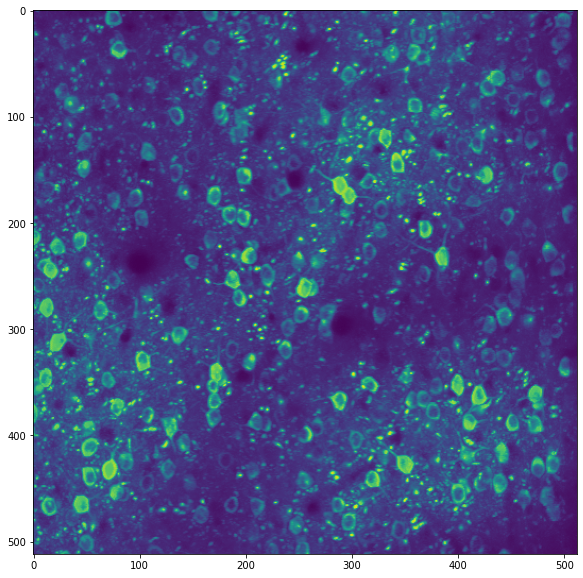

In [29]:
mxproj = data_set.get_max_projection()
fig,ax  = plt.subplots(figsize = (10,10))
ax.imshow(mxproj)

Number of labels: 291


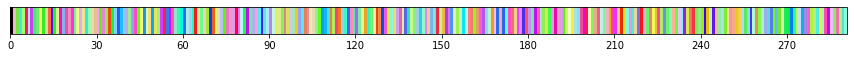

In [30]:
# This is just fancy code to give each cell a random, unique color - don't worry
# about it. If you really want to see whats happening, you can look at the code
# in 'helperfunctions.py'
from helperfunctions import rand_cmap
cm = rand_cmap(len(msks)+1)

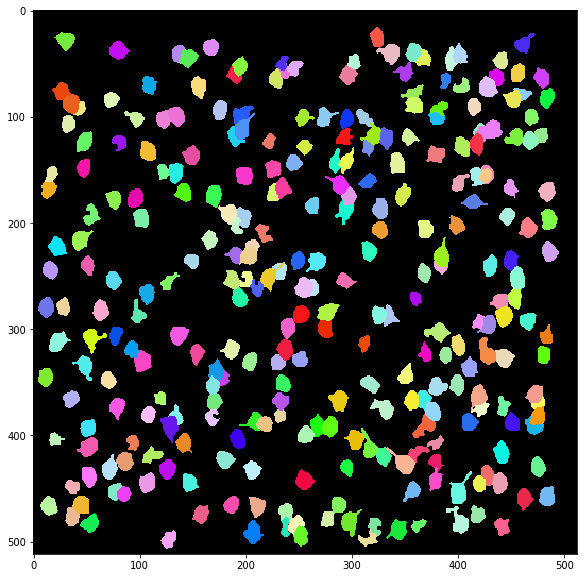

In [35]:
msks = data_set.get_roi_mask_array()

roi_id = np.zeros(msks[0].shape)
for ii, msk in enumerate(msks):
    roi_id[msk==1] = ii
fig,ax  = plt.subplots(figsize = (10,10))
ax.imshow(roi_id,cmap =cm,interpolation = 'none')


In [32]:
gratings = boc.get_ophys_experiment_analysis(ophys_experiment_id=session_id, stimulus_type='drifting_gratings')
gratings.dfftraces.shape

(290, 115741)

In [64]:
cell_id = 541513979
cell_idx = np.where(cell_id==gratings.cell_id)[0]

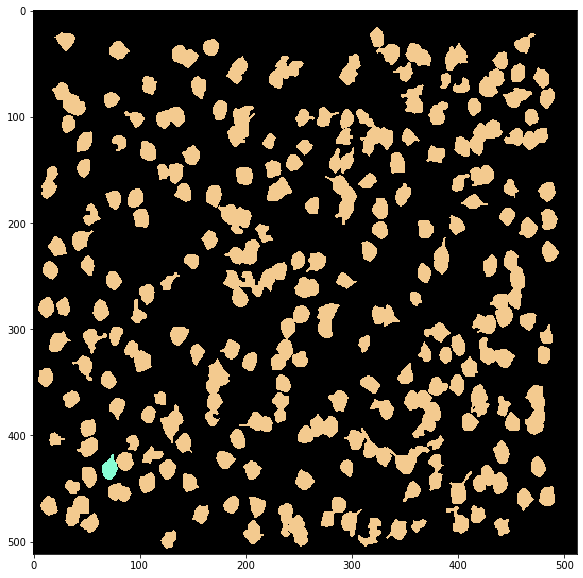

In [68]:
all_cell = (roi_id>0).astype(int)
all_cell[roi_id==cell_idx]+=1
fig,ax  = plt.subplots(figsize = (10,10))
ax.imshow(all_cell,cmap =cm,interpolation = 'none')

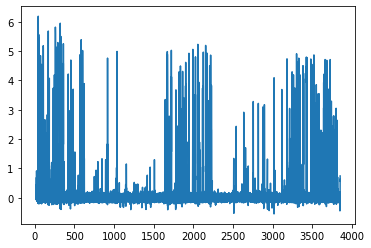

In [874]:
this_dff = gratings.dfftraces[cell_idx][0]
plt.plot(gratings.timestamps,this_dff)

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
<h2>The Analysis Object</h2>


<p>The analysis objects summarize the trial data for a stimulus type and provide convenient DataFrame objects.  
</div>

In [875]:
gratings = boc.get_ophys_experiment_analysis(ophys_experiment_id=session_id, stimulus_type='drifting_gratings')
gratings.dfftraces.shape

(290, 115741)

In [876]:
stim_table = gratings.stim_table
stim_table.head()

,temporal_frequency,orientation,blank_sweep,start,end
0,1.0,45.0,0.0,736,796
1,15.0,90.0,0.0,826,886
2,1.0,270.0,0.0,917,977
3,0.0,0.0,1.0,1007,1067
4,4.0,90.0,0.0,1098,1158


Text(0.5, 0, 'Frames')

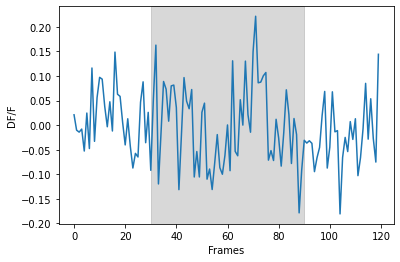

In [877]:
plt.plot(this_dff[stim_table.start[0]-30:stim_table.end[0]+30])
plt.axvspan(30,90, color='gray', alpha=0.3) #this shades the period when the stimulus is being presented
plt.ylabel("DF/F")
plt.xlabel("Frames")

Text(0.5, 0, 'Frames')

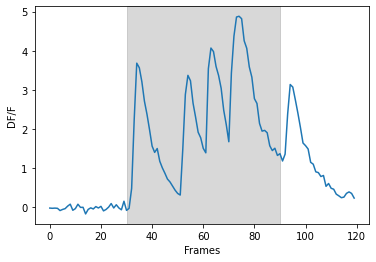

In [878]:
plt.plot(this_dff[stim_table.start[1]-30:stim_table.end[1]+30])
plt.axvspan(30,90, color='gray', alpha=0.3) #this shades the period when the stimulus is being presented
plt.ylabel("DF/F")
plt.xlabel("Frames")

In [879]:
this_stim_table = gratings.stim_table[(gratings.stim_table.temporal_frequency==15) & (gratings.stim_table.orientation==90)]
this_stim_table

,temporal_frequency,orientation,blank_sweep,start,end
1,15.0,90.0,0.0,826,886
48,15.0,90.0,0.0,5081,5141
97,15.0,90.0,0.0,9516,9576
134,15.0,90.0,0.0,12865,12925
170,15.0,90.0,0.0,16124,16184
188,15.0,90.0,0.0,17755,17814
254,15.0,90.0,0.0,53602,53661
332,15.0,90.0,0.0,60662,60722
349,15.0,90.0,0.0,62200,62260
410,15.0,90.0,0.0,95783,95843


In [880]:
len(this_stim_table)

15

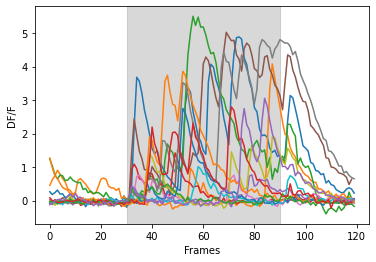

In [881]:
plt.axvspan(30,90, color='gray', alpha=0.3) #this shades the period when the stimulus is being presented

# THIS IS A SUPER HANDY WAY TO INTERATE THROUGH A TABLE!!!
for ii,row in this_stim_table.iterrows():
    plt.plot(this_dff[int(row.start)-30:int(row.end)+30])
    plt.ylabel("DF/F")
    plt.xlabel("Frames")

## 1.3 Are there direction selective cell in mouse primary visual cortex?


In [882]:
orientation = np.zeros((len(stim_table)))
temp_freq = np.zeros((len(stim_table)))
#mean_response= np.zeros((len(stim_table)))
response = np.zeros((len(stim_table),60))
for ii in range(len(stim_table)):
    orientation[ii] = stim_table.orientation[ii]
    temp_freq[ii] = stim_table.temporal_frequency[ii]
    response[ii,:] = this_dff[stim_table.start[ii]:stim_table.start[ii]+60]

In [883]:
response.shape

(628, 60)

In [884]:
orientations,ix = np.unique(orientation,return_inverse=True)
print(orientations)


[  0.  45.  90. 135. 180. 225. 270. 315.]


In [885]:
# The variable 'ix' maps the values in 'orientation' to the values in
# 'orientations'
print(ix[1:10])
print(orientation[1:10])
print(orientations[ix[1:10]])

[2 6 0 2 6 3 6 1 0]
[ 90. 270.   0.  90. 270. 135. 270.  45.   0.]
[ 90. 270.   0.  90. 270. 135. 270.  45.   0.]


In [886]:
# before we get too far, we are going to divide the data in half. Don't worry
# too much about this right now - eventually it will allow us to quantify some
# of the variability in our data, but we will talk about this at lenght later.
divider = len(orientation)//2

orientation_a = orientation[:divider]
orientation_b = orientation[divider:]
temp_freq_a = temp_freq[:divider]
temp_freq_b = temp_freq[divider:]
response_a = response[:divider,:]
response_b = response[divider:,:]
ix_a = ix[:divider]
ix_b = ix[divider:]


Text(0.5, 0, 'time (frames from stim onset)')

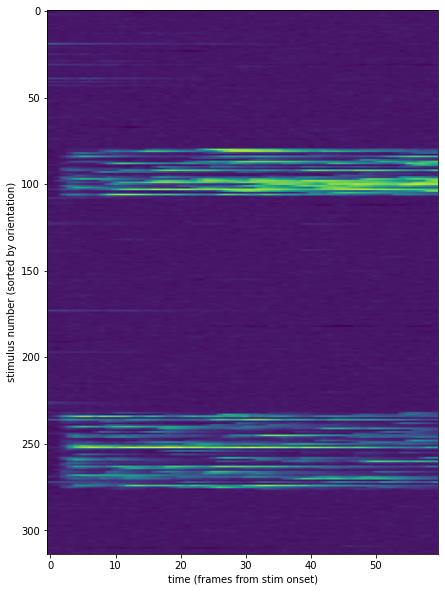

In [887]:
sort_order = np.argsort(ix_a)
fig,ax = plt.subplots(figsize=(7,10))
ax.imshow(response_a[sort_order,:],aspect='auto')
ax.set_ylabel('stimulus number (sorted by orientation)')
ax.set_xlabel('time (frames from stim onset)')


In [888]:
mean_response_a = response_a.mean(axis =1)
mean_response_b = response_b.mean(axis =1)

Text(0, 0.5, 'Trial Mean DF/F')

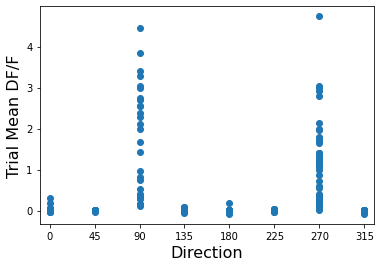

In [889]:
plt.plot(orientation_a, mean_response_a, 'o')
plt.xticks(orientations)
plt.xlim(-10,325)
plt.xlabel("Direction", fontsize=16)
plt.ylabel("Trial Mean DF/F", fontsize=16)

Text(0, 0.5, 'Mean DF/F')

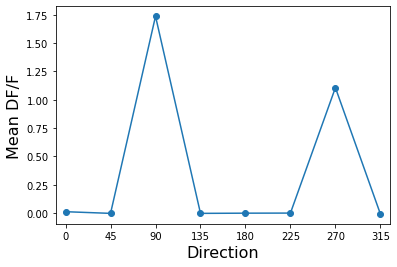

In [890]:
tuning_a = np.zeros(orientations.shape)
for ii in range(orientations.shape[0]):
    tuning_a[ii] = mean_response_a[ix_a==ii].mean()
plt.plot(orientations,tuning_a, 'o-')
plt.xticks(orientations)
plt.xlim(-10,325)
plt.xlabel("Direction", fontsize=16)
plt.ylabel("Mean DF/F", fontsize=16)

Conclusion: Are there direction selective cells in mouse V1? Its starting to look like there might be. But we don't actually know this yet!

# 2 How reliable are these responses?


In [891]:
prediction_aa = tuning_a[ix_a]

(array([  1.,   0.,   0.,   1.,   0.,   1.,   3.,   3.,   1.,   3.,   5.,
          6.,   7., 240.,   9.,   4.,   7.,  14.,   3.,   6.]),
 array([-3.6335275 , -3.37105454, -3.10858158, -2.84610862, -2.58363566,
        -2.3211627 , -2.05868974, -1.79621678, -1.53374382, -1.27127087,
        -1.00879791, -0.74632495, -0.48385199, -0.22137903,  0.04109393,
         0.30356689,  0.56603985,  0.82851281,  1.09098576,  1.35345872,
         1.61593168]),
 <BarContainer object of 20 artists>)

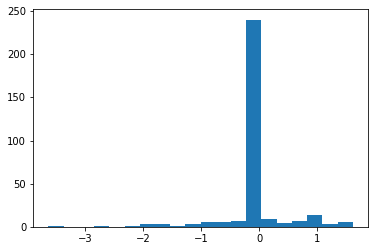

In [892]:
error = prediction_aa- mean_response_a
fig,ax = plt.subplots()
ax.hist(error,bins=20)


In [893]:
residuals_aa  =  np.mean((error)**2)
residuals_aa

0.2936974860941391

In [894]:
total_variance_aa = np.mean((mean_response_a-np.mean(mean_response_a))**2)
total_variance_aa

0.639987971643384

In [895]:
r2_aa = 1-residuals_aa/total_variance_aa
r2_aa

0.5410890530645878

Text(0, 0.5, 'Mean DF/F')

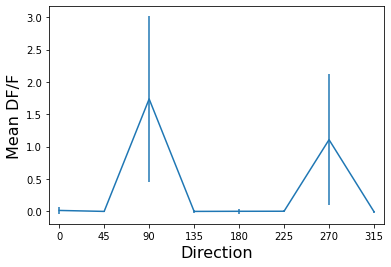

In [896]:
stdev_a = np.zeros(orientations.shape)
for ii in range(orientations.shape[0]):
    stdev_a[ii] = mean_response_a[ix_a==ii].std()

plt.errorbar(orientations,tuning_a,stdev_a)
plt.xticks(orientations)
plt.xlim(-10,325)
plt.xlabel("Direction", fontsize=16)
plt.ylabel("Mean DF/F", fontsize=16)

In [897]:
orientations.shape

(8,)

Text(0, 0.5, 'Mean DF/F')

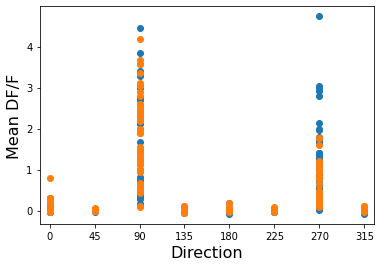

In [898]:
plt.scatter(orientation_a, mean_response_a,)
plt.scatter(orientation_b, mean_response_b,)

plt.xticks(orientations)
plt.xlim(-10,325)
plt.xlabel("Direction", fontsize=16)
plt.ylabel("Mean DF/F", fontsize=16)

In [1039]:
prediction_ab = tuning_a[ix_b]


In [1040]:
def compute_coefficient_of_determination(mean_response,prediction):
    """
    Compute the coefficient of determination (R^2) for a set of data
    Parameters
    ----------
    mean_response : np.array
        The mean response for each stimulus
    prediction : np.array
        The predicted response for each stimulus
    
    Returns
    -------
    r2 : float
        The coefficient of determination
    """

    residual = mean_response-prediction
    sum_of_squared_residual  =  np.mean((residual)**2)
    total = np.mean(mean_response)-mean_response
    sum_of_squared_total  =  np.mean((total)**2)
    r2 = 1-sum_of_squared_residual/sum_of_squared_total
    return r2

In [1041]:
r2_ab = compute_coefficient_of_determination(mean_response_b,prediction_ab)
r2_ab

0.6759775003228292

In [1048]:
orientation = np.zeros((len(stim_table)))
temp_freq = np.zeros((len(stim_table)))
response = np.zeros((len(stim_table),60))
mean_response_all = np.zeros((len(stim_table),len(gratings.cell_id)))
for ii in range(len(stim_table)):
    orientation[ii] = stim_table.orientation[ii]
    temp_freq[ii] = stim_table.temporal_frequency[ii]
    for cc in range(len(gratings.cell_id)):
        this_response =  gratings.dfftraces[cc][stim_table.start[ii]:stim_table.start[ii]+60]
        mean_response_all[ii,cc] = this_response.mean()

mean_response_all_a = mean_response_all[:divider,:]
mean_response_all_b = mean_response_all[divider:,:]



In [1049]:
new_cell_id = 541512233

In [1050]:
def compute_tuning_curve(mean_response,orientation,orientations):
    """
    Compute the tuning curve for a set of data
    """
    tuning = np.zeros(orientations.shape)
    stdev = np.zeros(orientations.shape)
    for ii,ori in enumerate(orientations):
        tuning[ii] = mean_response[orientation==ori].mean()
        stdev[ii] = mean_response[orientation==ori].std()
    return tuning,stdev
    

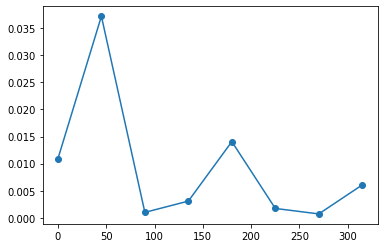

In [1051]:
this_index = np.where(gratings.cell_id==new_cell_id)[0][0]
this_tuning_a,this_stdev_a = compute_tuning_curve(mean_response_all_a[:,this_index],orientation_a,orientations) 

plt.plot(orientations,this_tuning_a, 'o-')



In [1052]:
print(compute_coefficient_of_determination(mean_response_all_a[:,this_index],this_tuning_a[ix_a]))
# Thought experiment: What to negative numbers mean here?


0.093898748760043


Text(0, 0.5, 'Mean DF/F')

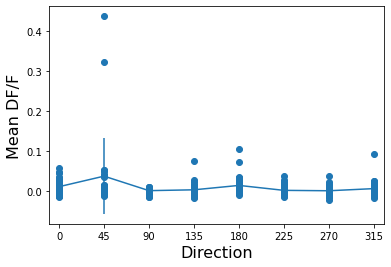

In [1053]:
fig,ax = plt.subplots()

ax.errorbar(orientations,this_tuning_a,this_stdev_a,)
ax.scatter(orientation_a,mean_response_all_a[:,this_index])

ax.set_xticks(orientations)
ax.set_xlim(-10,325)
ax.set_xlabel("Direction", fontsize=16)
ax.set_ylabel("Mean DF/F", fontsize=16)

-0.7590271758331917


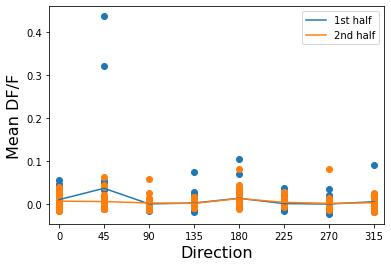

In [1054]:
fig,ax = plt.subplots()
ax.plot(orientations,this_tuning_a, '-',label = '1st half')
ax.scatter(orientation_a,mean_response_all_a[:,this_index])
this_tuning_b,this_stdev_b = compute_tuning_curve(mean_response_all_b[:,this_index],orientation_b,orientations)
ax.plot(orientations,this_tuning_b, '-',label = '2nd half')
ax.scatter(orientation_b,mean_response_all_b[:,this_index])
print(compute_coefficient_of_determination(mean_response_all_b[:,this_index],this_tuning_a[ix_b]))
ax.set_xticks(orientations)
ax.set_xlim(-10,325)
ax.set_xlabel("Direction", fontsize=16)
ax.set_ylabel("Mean DF/F", fontsize=16)
ax.legend()


So... a 'peak' in a tuning curve DOES NOT necessarily mean the cell is reliably tuned!

# 3 What do responses look like an a neural population?

In [1057]:

many_r2_aa = np.zeros(len(gratings.cell_id))
many_r2_ab = np.zeros(len(gratings.cell_id))
another_tuning_a = np.zeros((len(gratings.cell_id),orientations.shape[0]))
another_stdev_a = np.zeros((len(gratings.cell_id),orientations.shape[0]))

another_tuning_b = np.zeros((len(gratings.cell_id),orientations.shape[0]))
another_stdev_b = np.zeros((len(gratings.cell_id),orientations.shape[0]))

for cc in range(len(gratings.dfftraces)):
    another_dff = gratings.dfftraces[cc]

    another_response = np.zeros((len(stim_table),60))
    for ii in range(len(stim_table)):
        # Note that this is  the same session, so we can assume the same
        # stimulus order!
        another_response[ii,:] = another_dff[stim_table.start[ii]:stim_table.start[ii]+60]
    another_mean_response = another_response.mean(axis =1)

    another_mean_response_a = another_mean_response[:divider]
    another_mean_response_b = another_mean_response[divider:]

    another_tuning_a[cc,:],_ = compute_tuning_curve(another_mean_response_a,orientation_a,orientations)

    for ii in range(orientations.shape[0]):
        another_tuning_a[cc,ii] = another_mean_response_a[ix_a==ii].mean()
        another_stdev_a[cc,ii] = another_mean_response_a[ix_a==ii].std()
        another_tuning_b[cc,ii] = another_mean_response_b[ix_b==ii].mean()
        another_stdev_b[cc,ii] = another_mean_response_b[ix_b==ii].std()
    another_prediction_aa = another_tuning_a[cc,ix_a]
    another_prediction_ab = another_tuning_a[cc,ix_b]

    many_r2_aa[cc] = compute_coefficient_of_determination(another_mean_response_a,another_prediction_aa)
    many_r2_ab[cc] = compute_coefficient_of_determination(another_mean_response_b,another_prediction_ab)
    

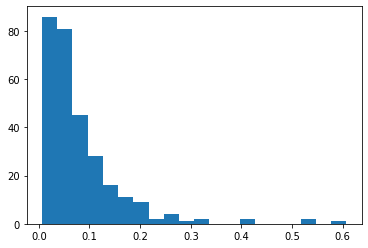

In [1058]:
fig,ax = plt.subplots()
ax.hist(many_r2_aa,bins=20);


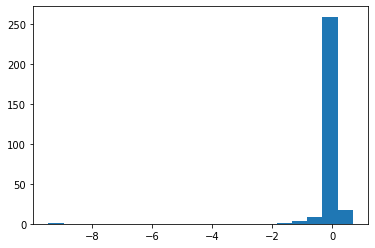

In [1059]:
fig,ax = plt.subplots()
ax.hist(many_r2_ab,bins=20);
# Yikes!

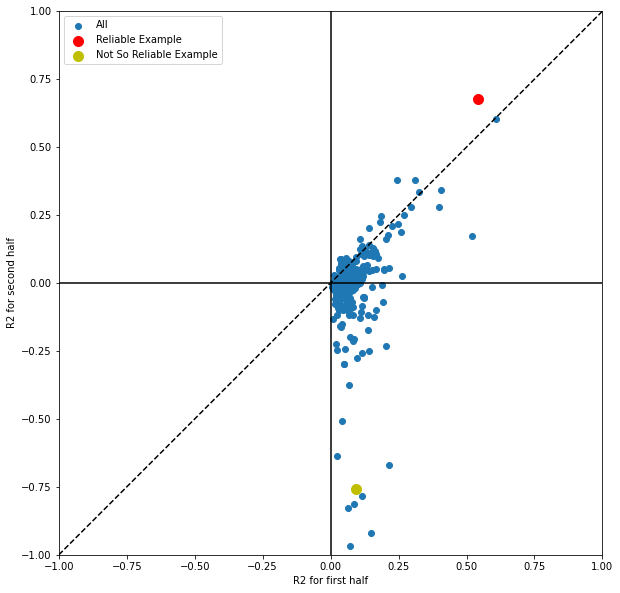

In [1060]:
fig,ax=plt.subplots(figsize=(10,10))
ax.scatter(many_r2_aa,many_r2_ab,label = 'All')
ax.scatter(r2_aa,r2_ab,c='r',s=100,label = 'Reliable Example')
this_index = np.where(gratings.cell_id==new_cell_id)[0][0]
ax.scatter(many_r2_aa[this_index],many_r2_ab[this_index],c='y',s=100,label = 'Not So Reliable Example')

ax.plot([-1,1],[-1,1],'k--')
ax.plot([-1,1],[0,0],'k')
ax.plot([0,0],[-1,1],'k')
ax.set_xlabel('R2 for first half')
ax.set_ylabel('R2 for second half')
ax.set_xlim(-1,1) # The lower bound here is arbitrarty...
ax.set_ylim(-1,1)
ax.set_aspect('equal')

ax.legend()

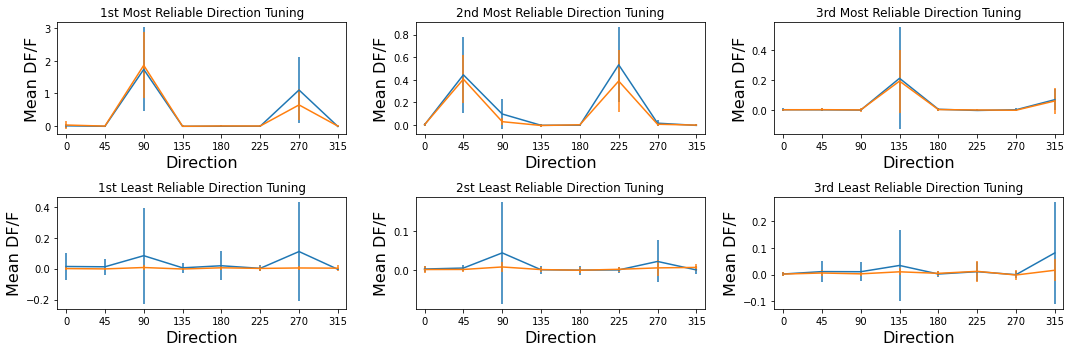

In [1061]:
order = np.argsort(many_r2_ab)
fig,ax = plt.subplots(ncols=3,nrows=  2,figsize=(15,5))
ax[0,0].errorbar(orientations, another_tuning_a[order[-1]],another_stdev_a[order[-1]],)
ax[0,0].errorbar(orientations, another_tuning_b[order[-1]],another_stdev_b[order[-1]],)
ax[0,0].set_title('1st Most Reliable Direction Tuning')

ax[0,1].errorbar(orientations, another_tuning_a[order[-2]],another_stdev_a[order[-2]],)
ax[0,1].errorbar(orientations, another_tuning_b[order[-2]],another_stdev_b[order[-2]],)
ax[0,1].set_title('2nd Most Reliable Direction Tuning')

ax[0,2].errorbar(orientations, another_tuning_a[order[-3]],another_stdev_a[order[-3]],)
ax[0,2].errorbar(orientations, another_tuning_b[order[-3]],another_stdev_b[order[-3]],)
ax[0,2].set_title('3rd Most Reliable Direction Tuning')


ax[1,0].errorbar(orientations, another_tuning_a[order[0]],another_stdev_a[order[0]],)
ax[1,0].errorbar(orientations, another_tuning_b[order[0]],another_stdev_b[order[0]],)
ax[1,0].set_title('1st Least Reliable Direction Tuning')


ax[1,1].errorbar(orientations, another_tuning_a[order[1]],another_stdev_a[order[1]],)
ax[1,1].errorbar(orientations, another_tuning_b[order[1]],another_stdev_b[order[1]],)
ax[1,1].set_title('2st Least Reliable Direction Tuning')

ax[1,2].errorbar(orientations, another_tuning_a[order[2]],another_stdev_a[order[2]],)
ax[1,2].errorbar(orientations, another_tuning_b[order[2]],another_stdev_b[order[2]],)
ax[1,2].set_title('3rd Least Reliable Direction Tuning')

for ii,x in enumerate(ax.flatten()):
    x.set_xticks(orientations)
    x.set_xlim(-10,325)
    x.set_xlabel("Direction", fontsize=16)
    x.set_ylabel("Mean DF/F", fontsize=16)
    


fig.set_tight_layout(True)


## 3.1 There is more than one way to split your data.
Up till now, all our analysis has focus on data that were split into the first and second halves of the behavior session. 

How, exactly, you split your data can have a profound impact on the question you are asking. Here,this means that our question wasn't just about the consistancy of data- it was about stability of neural responses between the first and second half of the session. 

One valid alternative would have been to grab random halves. Another might have been to grab alternating trials under each experiment condition. All of these would have told us something about neural consistancy, but each would have asked subtily different questions about our data and each would have made subtily different assumtions going in.

### 3.1.1 You can use carful data splits to answer scientific questions.

So far, we have thought about variability as a problem. Now though, lets try a stratigic split accross experimental conditions to see if we can learn something.




In [1062]:
fast_freqs = temp_freq>=2

slow_freqs = temp_freq<2


In [1063]:
fast_freqs_1 = np.bitwise_and(fast_freqs,stim_table.index<divider)
fast_freqs_2 = np.bitwise_and(fast_freqs,stim_table.index>=divider)

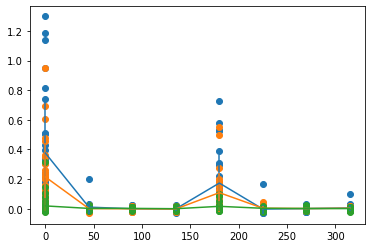

In [1064]:
new_cell_id = 541513083
this_index = np.where(gratings.cell_id==new_cell_id)[0][0]

this_tuning_fast_1,this_stdev_fast_1 = compute_tuning_curve(mean_response_all[fast_freqs_1,this_index],orientation[fast_freqs_1],orientations) 
this_tuning_fast_2,this_stdev_fast_2 = compute_tuning_curve(mean_response_all[fast_freqs_2,this_index],orientation[fast_freqs_2],orientations) 
this_tuning_slow,this_stdev_slow = compute_tuning_curve(mean_response_all[slow_freqs,this_index],orientation[slow_freqs],orientations) 

fig,ax = plt.subplots()
ax.errorbar(orientations,this_tuning_fast_1,this_stdev_fast_1)
ax.scatter(orientation[fast_freqs_1],mean_response_all[fast_freqs_1,this_index],label = 'Fast Freqs')

ax.errorbar(orientations,this_tuning_fast_2,this_stdev_fast_2)
ax.scatter(orientation[fast_freqs_2],mean_response_all[fast_freqs_2,this_index],label = 'Fast Freqs')

ax.errorbar(orientations,this_tuning_slow,this_stdev_slow)
ax.scatter(orientation[slow_freqs],mean_response_all[slow_freqs,this_index],label = 'Slow Freqs')


In [1065]:
many_r2_ff= np.zeros(len(gratings.cell_id))

many_r2_fs = np.zeros(len(gratings.cell_id))
another_tuning_moving = np.zeros((len(gratings.cell_id),orientations.shape[0]))
another_stdev_moving = np.zeros((len(gratings.cell_id),orientations.shape[0]))


ix_moving = ix[fast_freqs]
ix_not   = ix[~fast_freqs]

for cc in range(len(gratings.dfftraces)):
    another_tuning_moving[cc,:],another_stdev_moving[cc,:] =compute_tuning_curve(mean_response_all[fast_freqs_1,cc],orientation[fast_freqs_1],orientations) 

    another_prediction_mm = another_tuning_moving[cc,ix[fast_freqs_2]]
    another_prediction_mn = another_tuning_moving[cc,ix[slow_freqs]]

    many_r2_ff[cc] = compute_coefficient_of_determination(mean_response_all[fast_freqs_2,cc],another_prediction_mm)
    many_r2_fs[cc] = compute_coefficient_of_determination(mean_response_all[slow_freqs,cc],another_prediction_mn)

In [1066]:
print('Faster frequencies R^2: ' +str(many_r2_ff[this_index]))
print('Slower frequencies R^2: ' + str(many_r2_fs[this_index])) # Oh dear :(

Faster frequencies R^2: 0.12034526683709779
Slower frequencies R^2: -36.16624864063373


c:\Users\yoni.browning\Anaconda3\envs\allensdk\lib\site-packages\ipykernel_launcher.py:20: RuntimeWarning: Mean of empty slice.
c:\Users\yoni.browning\Anaconda3\envs\allensdk\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


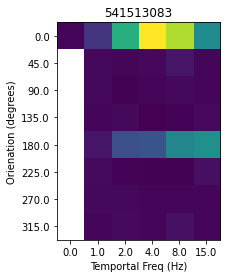

In [1067]:
another_dff = gratings.dfftraces[this_index]

another_response = np.zeros((len(stim_table),60))
for ii in range(len(stim_table)):
    orientation[ii] = stim_table.orientation[ii]
    temp_freq[ii] = stim_table.temporal_frequency[ii]
    another_response[ii,:] = another_dff[stim_table.start[ii]:stim_table.start[ii]+60]

another_mean_response = another_response.mean(axis =1)

temp_freqs = np.unique(temp_freq)

tuning_array = np.empty((len(orientations),len(temp_freqs)))
for ii,ori in enumerate(orientations):
    for jj,tf in enumerate(temp_freqs):
        #print(ori)
        #print(tf)
        these_trials = np.bitwise_and(orientation==ori,temp_freq==tf)
        #print(sum(these_trials))
        tuning_array[ii,jj] = another_mean_response[these_trials].mean()
fig,ax = plt.subplots()
ax.imshow(tuning_array)
ax.set_xticks(range(len(temp_freqs)))
ax.set_xticklabels(temp_freqs)
ax.set_yticks(range(len(orientations)))
ax.set_yticklabels(orientations);
ax.set_xlabel("Temportal Freq (Hz)")
ax.set_ylabel("Orienation (degrees)")
ax.set_title(gratings.cell_id[this_index]);

So what did this teach us? If we split our data between trials with fast and slow temporal frequencies, we can identify cells (or, at least, a cell) where the model prediction is particularly bad accross conditions. This indicates that temporal frequency is a factor that should also be considered when looking at a cells tuning!

# (4) How can we mathematically formalize this analysis?

One hot encodeing

Regression using matrix math

Regression using SKlearn


Evaluation on held out data

Cross validation and the arbitrary choices that go with it.

What did we gain from all this? Add in another variable (running or temporal freq or something)

Model Comparison

# Code Graveyard.
Not ready to delete yet - some of it will be reformated to fill in the gaps above!

c:\Users\yoni.browning\Anaconda3\envs\allensdk\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: Mean of empty slice.
  # Remove the CWD from sys.path while we load stuff.
c:\Users\yoni.browning\Anaconda3\envs\allensdk\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Text(0, 0.5, 'Orienation (degrees)')

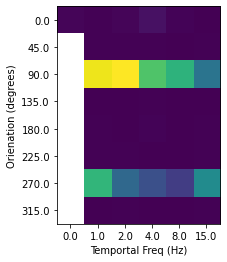

In [318]:
temp_freqs = np.unique(temp_freq)

tuning_array = np.empty((len(orientations),len(temp_freqs)))
for ii,ori in enumerate(orientations):
    for jj,tf in enumerate(temp_freqs):
        #print(ori)
        #print(tf)
        these_trials = np.bitwise_and(orientation==ori,temp_freq==tf)
        #print(sum(these_trials))
        tuning_array[ii,jj] = mean_response[these_trials].mean()
fig,ax = plt.subplots()
ax.imshow(tuning_array)
ax.set_xticks(range(len(temp_freqs)))
ax.set_xticklabels(temp_freqs)
ax.set_yticks(range(len(orientations)))
ax.set_yticklabels(orientations);
ax.set_xlabel("Temportal Freq (Hz)")
ax.set_ylabel("Orienation (degrees)")


<ipython-input-296-69dc6115fafe>:23: RuntimeWarning: Mean of empty slice.
  tuning_array[ii,jj] = another_mean_response[these_trials].mean()
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


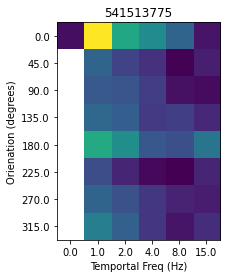

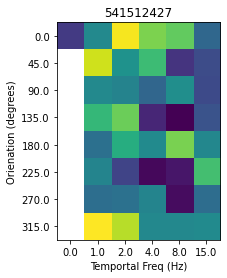

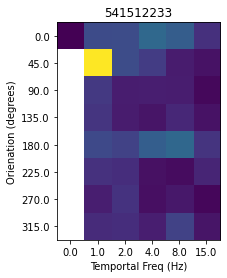

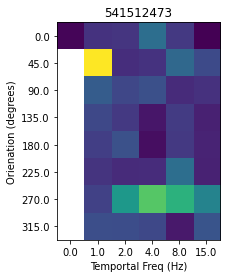

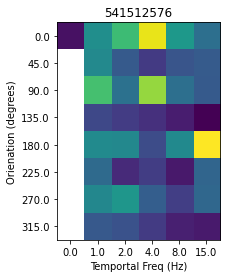

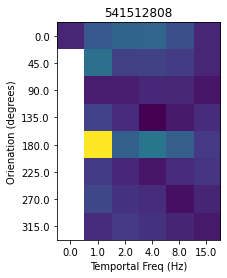

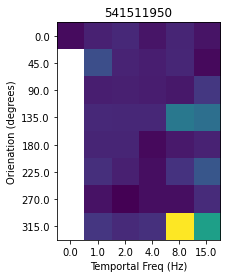

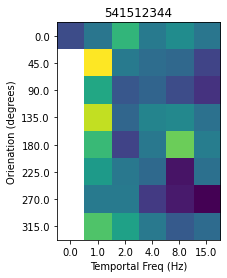

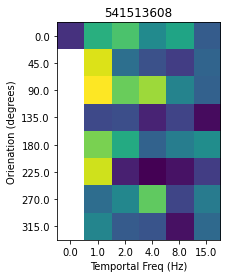

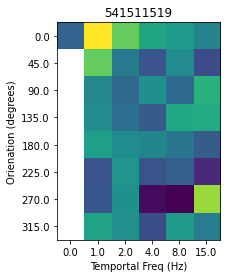

In [296]:
for ii in range(10):
    rand_cell_idx = np.random.randint(len(gratings.cell_id))

    another_dff = gratings.dfftraces[rand_cell_idx]

    another_response = np.zeros((len(stim_table),60))
    for ii in range(len(stim_table)):
        orientation[ii] = stim_table.orientation[ii]
        temp_freq[ii] = stim_table.temporal_frequency[ii]
        another_response[ii,:] = another_dff[stim_table.start[ii]:stim_table.start[ii]+60]

    another_mean_response = another_response.mean(axis =1)

    temp_freqs = np.unique(temp_freq)

    tuning_array = np.empty((len(orientations),len(temp_freqs)))
    for ii,ori in enumerate(orientations):
        for jj,tf in enumerate(temp_freqs):
            #print(ori)
            #print(tf)
            these_trials = np.bitwise_and(orientation==ori,temp_freq==tf)
            #print(sum(these_trials))
            tuning_array[ii,jj] = another_mean_response[these_trials].mean()
    fig,ax = plt.subplots()
    ax.imshow(tuning_array)
    ax.set_xticks(range(len(temp_freqs)))
    ax.set_xticklabels(temp_freqs)
    ax.set_yticks(range(len(orientations)))
    ax.set_yticklabels(orientations);
    ax.set_xlabel("Temportal Freq (Hz)")
    ax.set_ylabel("Orienation (degrees)")
    ax.set_title(gratings.cell_id[rand_cell_idx])


## We now interup our neuroscience programing
Up till now everything is descriptive- we are just looking at the data and describing it. What we really want to do is predict new data. In order to do this, we are going to fit a simple linear model that describes our tuning curve. Before we get that far, let's divert to the "DarwinExample" notebook to go though how model fitting and prediction might work on this kind of problem.

## Welcome back. 
This tuning curve problem can also be formulated as a one-hot encoding problem. -->Make this 1D

In [253]:
# Lets matrix for every stimulus condition
stims = np.vstack([orientation,temp_freq]).T

# Each stimulus condition has a unique identity
stimuli,stim_index,counts = np.unique(stims,axis=0,return_counts=True,return_inverse=True)

# How many are there?
print(len(stimuli))


41


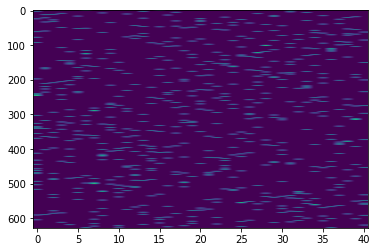

In [254]:
# Build the design matrix
X = np.zeros((len(stim_table),len(stimuli)))
for ii in range(len(stim_table)):
    X[ii,stim_index[ii]] = 1

fig,ax = plt.subplots()
ax.imshow(X,aspect='auto')

In [255]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, mean_response, test_size=0.5, random_state=42)


In [256]:
rfmodel = LinearRegression(fit_intercept=False).fit(X_train, y_train,)


In [257]:
# If we want to look at the model we fit, we can look at the predictions for any
# given stimulus. The easiest way to do this is to make a design matrix with a
# diagonal of all ones:
eyeX = np.eye(X.shape[1])
pred = rfmodel.predict(eyeX)

In [258]:
# Because we didn't fit an intercept, the predictions are the same as the as the
# model coefficients
rfmodel.coef_-pred

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0.])

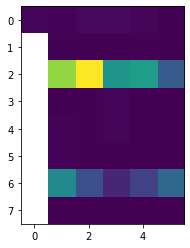

In [259]:
# We can plot the predicted response for each stimulus condition! This should
# look familiar... 
tuning_array = np.zeros((len(orientations),len(temp_freqs)))
for ii in range(len(pred)):
    ori_ix = np.where(orientations==stimuli[ii,0])[0]
    tf_ix = np.where(temp_freqs==stimuli[ii,1])[0]
    tuning_array[ori_ix,tf_ix]=pred[ii]
tuning_array[1:,0] = np.nan

fig,ax = plt.subplots()
ax.imshow(tuning_array)

In [260]:

scr_train = rfmodel.score(X_train,y_train)
scr_train

0.7941142710480253

In [261]:
# Now this is worse :(
scr_test = rfmodel.score(X_test,y_test)
scr_test

0.5737620030130027

In [219]:
train_prediction = np.zeros(len(gratings.cell_id))
test_prediction = np.zeros(len(gratings.cell_id))

for cc in range(len(gratings.dfftraces)):
    another_dff = gratings.dfftraces[cc]

    another_response = np.zeros((len(stim_table),60))
    for ii in range(len(stim_table)):
        orientation[ii] = stim_table.orientation[ii]
        temp_freq[ii] = stim_table.temporal_frequency[ii]
        another_response[ii,:] = another_dff[stim_table.start[ii]:stim_table.start[ii]+60]

    another_mean_response = another_response.mean(axis =1)

    another_X_train, another_X_test, another_y_train, another_y_test = train_test_split(X, another_mean_response, test_size=0.5,  random_state=42)
    
    rfmodel = LinearRegression(fit_intercept=False).fit(another_X_train, another_y_train,)
    train_prediction[cc] = rfmodel.score(another_X_train,another_y_train)

    test_prediction[cc] = rfmodel.score(another_X_test,another_y_test)


Text(0, 0.5, 'Test R^2')

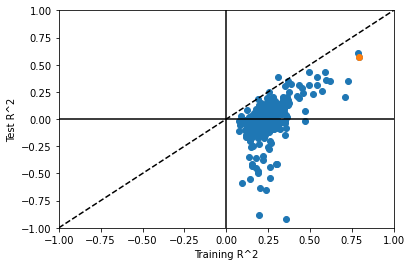

In [262]:
fig,ax = plt.subplots()
ax.scatter(train_prediction,test_prediction)
ax.scatter(scr_train,scr_test)

ax.plot([-1,1],[-1,1],'k--')
ax.plot([-1,1],[0,0],'k-')
ax.plot([0,0],[-1,1],'k-')
ax.set_xlim([-1,1])
ax.set_ylim([-1,1])
ax.set_xlabel("Training R^2")
ax.set_ylabel("Test R^2")

AttributeError: module 'matplotlib.pyplot' has no attribute 'histogram'

In [ ]:
run_speed,run_ts = data_set.get_running_speed()
fig,ax = plt.subplots()
ax.plot(run_ts,run_speed)
ax.set_xlabel('time (s)')
ax.set_ylabel('speed (cm/s)')   
